# Convolution Neural Networks

In [ ]:
#| default_exp models.conv

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import torch.nn as nn
import torch

from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateMonitor

from torch_lr_finder import LRFinder

from hydra.utils import instantiate
from omegaconf import OmegaConf

from matplotlib import pyplot as plt
import pandas as pd

from nimrod.utils import get_device
from nimrod.models.core import Classifier

import logging
logger = logging.getLogger(__name__)

## Overview
A lightweight, flexible Convolutional Neural Network (CNN) implementation using PyTorch, designed for image recognition tasks.

## Core Components

### ConvLayer
A customizable convolutional layer with unique downsampling strategy:
- Uses stride 2 convolution instead of traditional pooling
- Preserves more spatial information
- Optional ReLU activation

#### Key Parameters
- `in_channels`: Input channel count (default: 3)
- `out_channels`: Output channel count (default: 16)
- `kernel_size`: Convolution kernel size (default: 3)
- `activation`: Toggle ReLU activation (default: True)

### ConvNet
A sequential convolutional network for image classification:
- Progressive downsampling with ConvLayers
- Batch normalization after each layer
- Designed for MNIST-like image recognition

#### Network Architecture
- Input: Configurable input channels
- Layers: 5 ConvLayers with increasing channel depth
- Final layer: Flattened output for classification

## Features
- Dynamic network configuration
- Stride-based downsampling
- Batch normalization
- Flexible layer composition
- Logging integration

## Dependencies
- PyTorch
- Lightning
- Hydra
- OmegaConf

## Usage Example
```python
# Create ConvNet with custom configuration
convnet = ConvNet(
    in_channels=1,   # Grayscale images
    out_channels=10  # Number of classes
)

# Forward pass
output = convnet(input_tensor)
```

## Conv Layer

Using a convolution with a stride of 2 instead of max pooling essentially achieves the same goal of downsampling an image by reducing its spatial dimensions, but with the key difference that the convolution layer can learn more complex feature combinations from overlapping regions, while max pooling only selects the maximum value within a window, potentially losing information about the finer details within that region; making the convolution with stride approach often preferred for preserving more spatial information in a neural network. 

In [ ]:
#| export
class ConvLayer(nn.Module):
    """
    Convolutional layer for 2D images.

    Parameters
    ----------
    in_channels : int, optional
        Number of input channels. The default is 3.
    out_channels : int, optional
        Number of output channels. The default is 16.
    kernel_size : int, optional
        Size of the kernel (filter). The default is 3.
    activation : bool, optional
        Whether to apply ReLU activation after convolution. The default is True.

    Returns
    -------
    torch.Tensor
        Output image tensor of dimension (B, C, W/2, H/2)

    """

    
    def __init__(
        self,
        in_channels:int=3, # input channels
        out_channels:int=16, # output channels
        kernel_size:int=3, # kernel size
        activation:bool=True
    ):

        super().__init__()
        self.activation = activation
        # use stride 2 for downsampling to (W/2, H/2) instead of max or average pooling with stride 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=kernel_size//2)
        self.relu = nn.ReLU()

    def forward(self, x:torch.Tensor # input image tensor of dimension (B, C, W, H)
                ) -> torch.Tensor: # output image tensor of dimension (B, C, W/2, H/2)
        x = self.conv(x)
        if self.activation:
            x = self.relu(x)
        return x

In [ ]:
show_doc(ConvLayer.forward)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/models/conv.py#L65){target="_blank" style="float:right; font-size:smaller"}

### ConvLayer.forward

>      ConvLayer.forward (x:torch.Tensor)

*Define the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | input image tensor of dimension (B, C, W, H) |
| **Returns** | **Tensor** | **output image tensor of dimension (B, C, W/2, H/2)** |

### Usage

In [ ]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
# stride 2 layer downsample to (W/2, H/2)
net = ConvLayer(in_channels=C, out_channels=16, kernel_size=3, activation=True)
print("Y: ",net(X).shape)
# flatten all dims except batch dim 1
Y = torch.flatten(net(X), 1)
print(Y.shape)

Y:  torch.Size([64, 16, 14, 14])
torch.Size([64, 3136])


## Convnet Model
Simple convolution network for image recognition

In [ ]:
#| export

class ConvNet(nn.Module):
    """
    Convolutional neural network for 2D images.

    Parameters
    ----------
    in_channels : int, optional
        Number of input channels. The default is 1.
    out_channels : int, optional
        Number of output channels (number of classes in classification).
        The default is 10.

    Returns
    -------
    torch.Tensor
        Output probability tensor of dimension (B, N_classes)

    """
    

    
    def __init__(
            self,
            in_channels:int=1, # input channels
            out_channels:int=10 # num_classes
            ):
        super().__init__()
        self.net = nn.Sequential(
            ConvLayer(in_channels, 8, kernel_size=5), #14x14
            nn.BatchNorm2d(8),
            ConvLayer(8, 16), #7x7
            nn.BatchNorm2d(16),
            ConvLayer(16, 32), #4x4
            nn.BatchNorm2d(32),
            ConvLayer(32, 64), #2x2
            nn.BatchNorm2d(64),
            ConvLayer(64, 10, activation=False), #1x1
            nn.BatchNorm2d(10),
            nn.Flatten()

        )

    def forward(
        self,
        x:torch.Tensor # input image tensor of dimension (B, C, W, H)
        ) -> torch.Tensor: # output probs (B, N_classes)

        """
        Parameters
        ----------
        x : torch.Tensor
            Input image tensor of dimension (B, C, W, H)

        Returns
        -------
        torch.Tensor
            Output probs of dimension (B, N_classes)
        """

        return self.net(x)

In [ ]:
show_doc(ConvNet.forward)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/models/conv.py#L115){target="_blank" style="float:right; font-size:smaller"}

### ConvNet.forward

>      ConvNet.forward (x:torch.Tensor)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | input image tensor of dimension (B, C, W, H) |
| **Returns** | **Tensor** | **output probs (B, N_classes)** |

### Usage

#### Mock data

In [ ]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
X.shape

torch.Size([64, 1, 28, 28])

#### Model

In [ ]:
# model instantiation
convnet = ConvNet()
out = convnet(X)
print(out.shape)

# from config
cfg = OmegaConf.load('../config/image/model/conv.yaml')
print(cfg.nnet)
convnet = instantiate(cfg.nnet)
print(convnet(X).shape)

torch.Size([64, 10])
{'_target_': 'nimrod.models.conv.ConvNet', 'in_channels': 1, 'out_channels': '${num_classes}'}
torch.Size([64, 10])


### Training

#### Dataloaders

In [ ]:
#| notest

# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')

datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.batch_size = 2048
datamodule.setup()

# one data point 
X,y = datamodule.test_ds[0]
print("X (C,H,W): ", X.shape, "y: ", y)

# a batch of data via dataloader
XX,YY = next(iter(datamodule.test_dataloader()))
print("XX (B,C,H,W): ", XX.shape, "YY: ", YY.shape)

print(len(datamodule.train_ds))
print(len(datamodule.train_ds)//cfg.datamodule.batch_size)

[17:04:27] INFO - Init ImageDataModule for mnist
[17:04:27] INFO - mnist Dataset: init
[17:04:34] INFO - mnist Dataset: init
[17:04:37] INFO - split train into train/val [0.8, 0.2]
[17:04:37] INFO - train: 48000 val: 12000, test: 10000


X (C,H,W):  torch.Size([1, 28, 28]) y:  7
XX (B,C,H,W):  torch.Size([64, 1, 28, 28]) YY:  torch.Size([64])
48000
750


#### Model & hardware

In [ ]:
device = get_device()
print(device)
model = ConvNet()
model = model.to(device)

[18:48:10] INFO - Using device: mps


mps


#### Loss, optimizer, scheduler

##### LR finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.27E-01


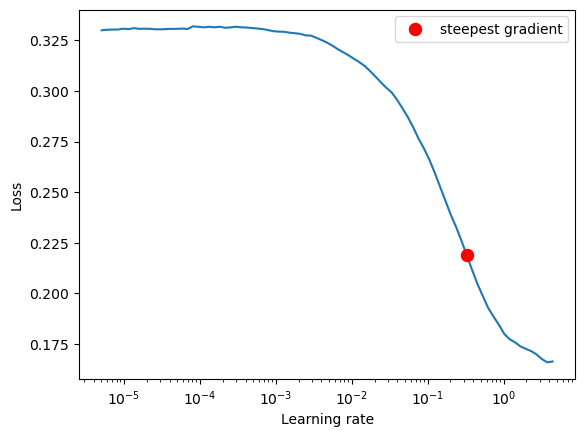

Suggested lr: 0.3274549162877726


In [ ]:
#| notest

criterion = nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
# Initialize LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
    
# Run LR range test
lr_finder.range_test(
    datamodule.train_dataloader(),
    start_lr=1e-6,      # Extremely small starting learning rate
    end_lr=10,          # Large ending learning rate
    num_iter=100,   # Number of iterations to test
    smooth_f=0.05,   # Smoothing factor for the loss
    diverge_th=5, 
)
    
# Plot the learning rate vs loss
_, lr_found = lr_finder.plot(log_lr=True)
print('Suggested lr:', lr_found)
    
lr_finder.reset()
    

    

##### 1-cycle training loop

In [ ]:
#| notest

# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.datamodule.batch_size = 2048
datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.setup()

# device = 'cpu'
print(device)
model = ConvNet()
model = model.to(device)

N_EPOCHS = 5

lr_found = 0.32 # from lr finder

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
steps_per_epoch = len(datamodule.train_ds) // cfg.datamodule.batch_size
total_steps = steps_per_epoch* N_EPOCHS
print(len(datamodule.train_ds), cfg.datamodule.batch_size, steps_per_epoch, total_steps)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps_per_epochs, epochs=1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr_found,  # Peak learning rate
        # total_steps=len(datamodule.train_ds) * N_EPOCHS,  # Total training iterations
        steps_per_epoch=steps_per_epoch,
        epochs=N_EPOCHS,
        pct_start=0.3,  # 30% of training increasing LR, 70% decreasing
        anneal_strategy='cos',  # Cosine annealing
        div_factor=10,  # Initial lr = max_lr / div_factor
        # final_div_factor=1e4,
        three_phase=False  # Two phase LR schedule (increase then decrease)
    )

%time
losses = []
lrs = []
current_step = 0

for epoch in range(N_EPOCHS):
    i = 0
    model.train()
    for images, labels in datamodule.train_dataloader():
        if current_step >= total_steps:
            print(f"Reached total steps: {current_step}/{total_steps}")
            break
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        scheduler.step()    
        current_step += 1
    
        losses.append(loss.item())
        # current_lr = scheduler.get_last_lr()[0]
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        if not (i % 100):
            print(f"Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        i += 1
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in datamodule.test_dataloader():
            # model expects input (B,H*W)
            images = images.to(device)
            labels = labels.to(device)
            # Pass the input through the model
            outputs = model(images)
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum()

        # Print the accuracy
    print(f"Epoch {epoch + 1}: Loss {loss.item():.4f}, Accuracy = {100 * correct / total:.2f}%")
    # print(f'Current LR: {optimizer.param_groups[0]["lr"]:.5f}')



[20:18:01] INFO - Init MNIST DataModule
[20:18:01] INFO - MNISTDataset: init
[20:18:01] INFO - ImageDataset: init
[20:18:07] INFO - MNISTDataset: init
[20:18:07] INFO - ImageDataset: init


mps
56000 2048 27 135
CPU times: user 3 μs, sys: 4 μs, total: 7 μs
Wall time: 3.1 μs
Loss 2.8485, Current LR: 0.0324552072, Step: 1/135
Epoch 1: Loss 0.1268, Accuracy = 92.50%
Loss 0.1315, Current LR: 0.2726381737, Step: 29/135
Epoch 2: Loss 0.0610, Accuracy = 96.37%
Loss 0.0750, Current LR: 0.2936783130, Step: 57/135
Epoch 3: Loss 0.0477, Accuracy = 97.36%
Loss 0.0423, Current LR: 0.1693046796, Step: 85/135
Epoch 4: Loss 0.0336, Accuracy = 98.36%
Loss 0.0348, Current LR: 0.0374357148, Step: 113/135
Reached total steps: 135/135
Epoch 5: Loss 0.0343, Accuracy = 98.44%


[<matplotlib.lines.Line2D>]

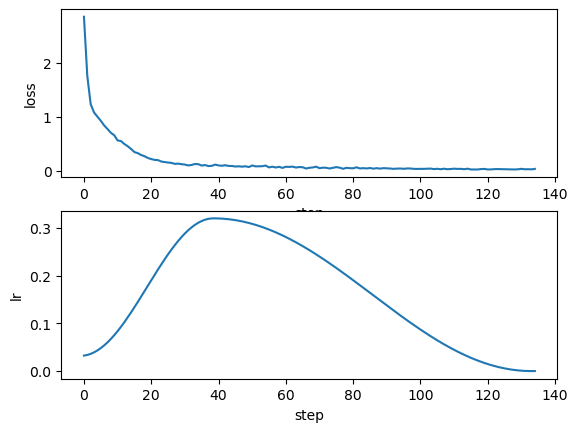

In [ ]:
#| notest
plt.figure(1)
plt.subplot(211)
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(losses)
plt.subplot(212)
plt.ylabel('lr')
plt.xlabel('step')
plt.plot(lrs)

## ConvNetX

In [ ]:
#| export

class ConvNetX(Classifier, LightningModule):
    def __init__(
            self,
            nnet:ConvNet,
            num_classes:int,
            optimizer:torch.optim.Optimizer,
            scheduler:torch.optim.lr_scheduler,
            ):
        logger.info("ConvNetX: init")
        super().__init__(num_classes, optimizer, scheduler)
        self.register_module('nnet', nnet)
        self.save_hyperparameters(logger=False, ignore=['nnet'])
        self.lr = optimizer.keywords['lr'] # for lr finder
        self.nnet = nnet

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)
    
    def _step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)

### Usage

In [ ]:
cfg = OmegaConf.load('../config/image/model/conv.yaml')
model = instantiate(cfg)

[18:53:56] INFO - ConvNetX: init
[18:53:56] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


In [ ]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
X.shape
print(model(X).shape)

torch.Size([64, 10])


### Nimrod training

In [ ]:
# model
model_cfg = OmegaConf.load('../config/image/model/conv.yaml')
model = instantiate(model_cfg)

# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.datamodule.batch_size = 2048
cfg.datamodule.num_workers = 0
datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.setup()

[19:26:58] INFO - ConvNetX: init
[19:26:58] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
[19:26:58] INFO - Init MNIST DataModule
[19:26:58] INFO - MNISTDataset: init
[19:26:58] INFO - ImageDataset: init
[19:27:03] INFO - MNISTDataset: init
[19:27:03] INFO - ImageDataset: init


In [ ]:
dl = datamodule.test_dataloader()
print(next(iter(dl))[0].shape)
print(next(iter(dl))[1].shape)

torch.Size([2048, 1, 28, 28])
torch.Size([2048])


In [ ]:
N_EPOCHS = 5

trainer = Trainer(
    accelerator="auto",
    max_epochs=N_EPOCHS,
    logger=TensorBoardLogger("tb_logs", name="mnist_convnet", default_hp_metric=True),
    # logger=CSVLogger("logs", name="mnist_convnet"),
    callbacks = [LearningRateMonitor(logging_interval="step")],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[19:20:14] INFO - MNISTDataset: init
[19:20:14] INFO - ImageDataset: init
[19:20:19] INFO - MNISTDataset: init
[19:20:19] INFO - ImageDataset: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/nbs/.lr_find_6b4a07f3-c717-402c-90a8-f295c121ab4d.ckpt
Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/nbs/.lr_find_6b4a07f3-c717-402c-90a8-f295c121ab4d.ckpt


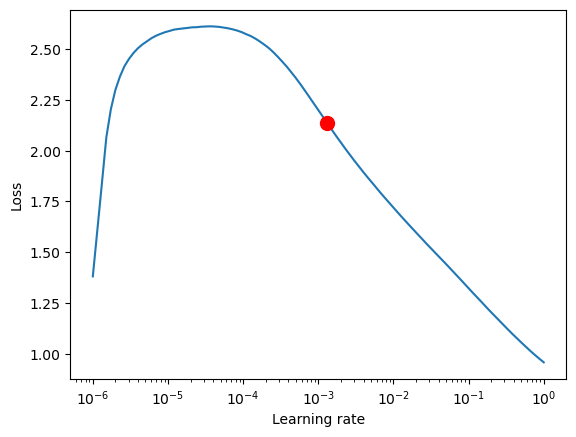

Suggested learning rate: 0.0013182567385564075


In [ ]:
#| notest

tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    model,
    datamodule=datamodule,
    min_lr=1e-6,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)
fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")

In [ ]:
print(trainer.max_epochs, len(datamodule.train_ds), datamodule.hparams.batch_size)
print(5*56000)
print(5*56000/2048)
print(5*56000//2048)

5 56000 2048
280000
136.71875
136


In [ ]:
#| notest

N_EPOCHS = 5

trainer = Trainer(
    accelerator="auto",
    max_epochs=N_EPOCHS,
    # logger=TensorBoardLogger("tb_logs", name="mnist_convnet", default_hp_metric=True),
    logger=CSVLogger("logs", name="mnist_convnet"),
    callbacks = [LearningRateMonitor(logging_interval="step")],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )

print("estimated steps: ", trainer.estimated_stepping_batches, "accumulate_grad_batches: ", trainer.accumulate_grad_batches)
# model
model_cfg = OmegaConf.load('../config/image/model/conv.yaml')
model = instantiate(model_cfg)
steps_per_epoch = len(datamodule.train_ds) // cfg.datamodule.batch_size // trainer.accumulate_grad_batches
print("Steps per epoch: ", steps_per_epoch)
# model_cfg.scheduler.steps_per_epoch = steps_per_epoch
model_cfg.scheduler.epochs = N_EPOCHS 
# estimated_steps = N_EPOCHS * len(datamodule.train_ds) // cfg.datamodule.batch_size
model_cfg.scheduler.total_steps = trainer.max_epochs *len(datamodule.train_ds) // cfg.datamodule.batch_size
model_cfg.scheduler.max_lr = 0.32 #lr_finder.suggestion()
model_cfg.scheduler.pct_start = 0.3
model_cfg.scheduler.anneal_strategy = 'cos'
model_cfg.scheduler.div_factor = 10

model = instantiate(model_cfg)
print("LR: ",model.lr)

trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader())


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.
[10:50:56] INFO - ConvNetX: init
[10:50:56] INFO - Classifier: init
[10:50:56] INFO - ConvNetX: init
[10:50:56] INFO - Classifier: init
[10:50:56] INFO - Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
[10:50:56] INFO - Scheduler: <torch.optim.lr_scheduler.OneCycleLR object>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | MulticlassAccuracy | 0      | train
4 | train_loss   | M

estimated steps:  -1 accumulate_grad_batches:  1
Steps per epoch:  27
LR:  0.0001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[10:51:05] WARNING - Max steps reached for 1-cycle LR scheduler
[10:51:05] WARNING - Max steps reached for 1-cycle LR scheduler
[10:51:05] WARNING - Max steps reached for 1-cycle LR scheduler
[10:51:05] WARNING - Max steps reached for 1-cycle LR scheduler


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
#| notest
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head()

,epoch,lr-Adam,step,train/acc_epoch,train/acc_step,train/loss_epoch,train/loss_step,val/acc,val/acc_best,val/loss
0,NaN,0.032000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,0,NaN,0.122070,NaN,2.610127,NaN,NaN,NaN
2,NaN,0.032448,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1,NaN,0.479492,NaN,1.630705,NaN,NaN,NaN
4,NaN,0.033791,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


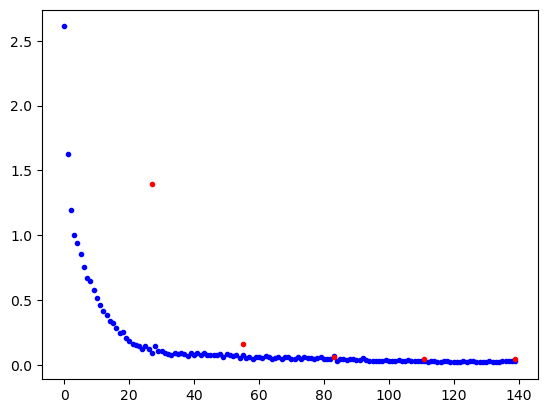

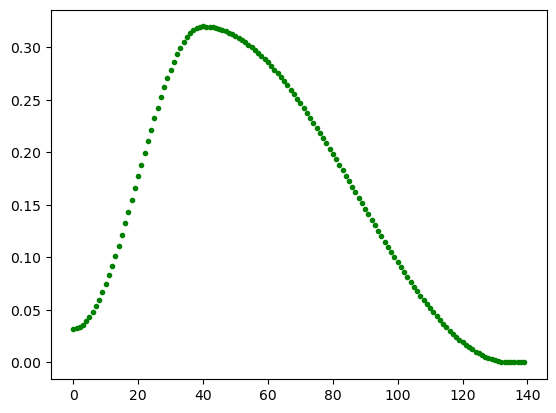

In [ ]:
#| notest
plt.figure()
plt.plot(metrics['step'], metrics['train/loss_step'], 'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.figure()
plt.plot(metrics['step'], metrics['lr-Adam'], 'g.-')
plt.show()

In [ ]:
#| notest
trainer.test(model, datamodule.test_dataloader(), ckpt_path="best")

Restoring states from the checkpoint path at logs/mnist_convnet/version_16/checkpoints/epoch=4-step=136.ckpt
Loaded model weights from the checkpoint at logs/mnist_convnet/version_16/checkpoints/epoch=4-step=136.ckpt
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9852856993675232     │
│         test/loss         │    0.04788264259696007    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.04788264259696007, 'test/acc': 0.9852856993675232}]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()